In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

import requests
from bs4 import BeautifulSoup as bs

In [ ]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36"
}

In [ ]:
# Get album list

artist_id = "261143"
url = "https://www.melon.com/artist/album.htm?artistId=261143#params%5BlistType%5D=0&params%5BorderBy%5D=ISSUE_DATE&params%5BartistId%5D=261143&po=pageObj&startIndex="
album_list = []

for index in range(0,4):
  params = {'startIndex': str(index * 15 + 1)}
  res = requests.get(url, params=params, headers=headers)

  res = requests.get(url+str(index*15+1), headers=headers)
  soup = bs(res.text, 'html.parser')
  albums = soup.find_all('div', {'class':'wrap_album04'})

  for album in albums:
    if (album.find('span', {'class':'vdo_name'}).text.strip('[]') in ['EP', '정규'] and (album.find('a', {'class':'play_artist'}).span.text == '아이유')):
      album_list.extend(re.findall(r'[0-9]{6,8}', album.find('a').attrs['href']))
      

In [ ]:
album_list = ['10827816', '10554246', '10346650', '10096855', '10056666', '2646282', '2256290', 
              '2222587', '2208448', '2040666', '1093562', '718505', '546853', '398025']

In [ ]:
album_df = pd.DataFrame(columns = ['album_id', 'title', 'year'])
album_df['album_id'] = album_list

In [ ]:
# Get song, lyrics, metadata

def get_songs(album_df):
  album_id_list = []
  song_id_list = []
  song_title_list = []
  lyrics_list = []
  genre_list = []

  for album_id in tqdm(album_df['album_id']):
    album_url = "https://www.melon.com/album/detail.htm?albumId=" + album_id

    res = requests.get(album_url, headers=headers)
    soup = bs(res.text, 'html.parser')

    # Get album
    title = soup.select_one('div.song_name').text
    title = re.sub(r"[\r\n\t앨범명]", "", title)
    year = soup.select_one('div.meta').select('dd')[0].text[0:4]

    album_df.loc[album_df['album_id']==album_id] = [album_id, title, year]


    # Get songs
    songs = []
    for song in soup.find_all('a', attrs={'class': 'btn button_icons type03 song_info'}):
      songs.append(song.attrs['href'])

    for song in songs:
      song_id = re.findall(r'[0-9]{7,9}', song)[0]
      song_url = "https://www.melon.com/song/detail.htm?songId=" + str(song_id)
      song_res = requests.get(song_url, headers=headers)
      song_soup = bs(song_res.text, 'html.parser')

      title = song_soup.find('div', {'class':'song_name'}).text
      title = re.sub(r"[\n\t\r곡명]", "", title)
      genre = song_soup.find('div', {'class':'meta'}).find_all('dd')[2].text
      lyrics = song_soup.find('div', {'id':'d_video_summary'})
      lyrics = re.sub(r'<[^>]*>', " ", str(lyrics)).strip()

      album_id_list.append(album_id)
      song_id_list.append(song_id)
      song_title_list.append(title)
      lyrics_list.append(lyrics)
      genre_list.append(genre)

  try :
    song_df = pd.DataFrame({'album_id' : album_id_list, 
                        'song_id' : song_id_list, 
                        'song_title' : song_title_list, 
                        'lyrics': lyrics_list, 
                        'genre':genre_list})
  except :
    return album_id_list, song_id_list, song_title_list, lyrics_list, genre_list
      
  return song_df


In [ ]:
song_df = get_songs(album_df)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
song_df

,album_id,song_id,song_title,lyrics,genre
0,10827816,34481680,드라마,나도 한때는 그이의 손을 잡고 내가 온 세상 주인공이 된 듯 꽃송이의 꽃잎 하나하나...,발라드
1,10827816,34481681,정거장,다음 정거장에서 만나게 될까 그리워했던 얼굴을 다음 파란불에는 만나게 될까 그리곤 ...,포크/블루스
2,10827816,34481682,겨울잠,때 이른 봄 몇 송이 꺾어다 너의 방 문 앞에 두었어 긴 잠 실컷 자고 나오면 그때...,발라드
3,10827816,34481683,너,아득히 떨어진 곳에서 아무 관계없는 것들을 보며 조금 쓸쓸한 기분으로 나는 너를 보...,포크/블루스
4,10827816,34481684,러브레터,골목길 머뭇하던 첫 안녕을 기억하오 그날의 끄덕임을 난 잊을 수 없다오 길가에 내...,발라드
...,...,...,...,...,...
123,398025,1929324,미아,우리 둘 담아 준 사진을 태워 하나 둘 모아 둔 기억을 지워 그만 일어나 가야 하는...,발라드
124,398025,1929325,있잖아 (Feat. 마리오),Ye this song is my love story 첫 눈에 반한다는 말 절대로 ...,댄스
125,398025,1929326,Feel So Good,아침에 눈을 뜨면 다가오는 햇살 햇살에 눈 비비고 일어나고 일어나 남은 잠을 깨워보...,발라드
126,398025,1929327,Every Sweet Day,Hey boy what you gonna do for me honey 내 방안에 ...,발라드


In [ ]:
song_df[song_df['song_title'].str.contains('Inst')]

In [ ]:
song_df = song_df[song_df['song_title'].str.contains('Inst')==False]

In [ ]:
song_df['album_id'].nunique()

14

In [ ]:
song_df['song_id'].nunique()

128

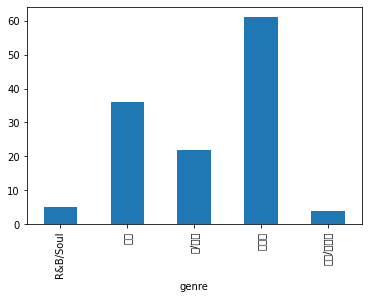

In [ ]:
song_df.groupby(['genre']).song_id.count().plot.bar()

In [ ]:
path = '/content/drive/MyDrive/text_mining_project/data/'
song_df.to_csv(path+'song.csv')
album_df.to_csv(path+'album.csv')